# 1. Data Loading and Preprocessing

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data from Yahoo Finance (Upload your CSV file)
from google.colab import drive
drive.mount('/content/drive')

# Read CSV file into DataFrame and set 'Date' as index
DJIA_path = '/content/drive/MyDrive/FINAL PROJECT/DJIA_table(train).csv'
djia_data = pd.read_csv(DJIA_path)

# Read CSV file into DataFrame and set 'Date' as index
reddit_path = '/content/drive/MyDrive/FINAL PROJECT/RedditNews(train).csv'
reddit_data = pd.read_csv(file_path)

# Initialize the VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment polarity using VADER
def calculate_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    return round(score['compound'], 3)

# Calculate sentiment scores for Reddit news
reddit_data['SentimentScore'] = reddit_data['News'].apply(calculate_vader_sentiment)

# Aggregate sentiment scores by date
sentiment_by_date = reddit_data.groupby('Date')['SentimentScore'].mean().reset_index()

# Convert date columns to a consistent format
sentiment_by_date['Date'] = pd.to_datetime(sentiment_by_date['Date'])
djia_data['Date'] = pd.to_datetime(djia_data['Date'], dayfirst=True)

# Merge the datasets on the 'Date' column
merged_data = pd.merge(djia_data, sentiment_by_date, how='inner', on='Date')

# Select required columns
final_dataset = merged_data[['Date', 'Close', 'SentimentScore']]

# Sort the dataset by date in ascending order
final_dataset = final_dataset.sort_values(by='Date', ascending=True)

# Print a preview of the resulting dataset
print(final_dataset.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           Date        Close  SentimentScore
1862 2008-08-08  11734.32031        -0.35420
1861 2008-08-11  11782.34961        -0.15876
1860 2008-08-12  11642.46973        -0.19172
1859 2008-08-13  11532.95996        -0.14180
1858 2008-08-14  11615.92969        -0.13684


# 2. Data Normalization

In [31]:
# Normalize the 'Close' price using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset['NormalizedClose'] = scaler.fit_transform(final_dataset[['Close']])

# Display the scaled data
print(final_dataset[:5])

           Date        Close  SentimentScore  NormalizedClose
1862 2008-08-08  11734.32031        -0.35420         0.440894
1861 2008-08-11  11782.34961        -0.15876         0.444976
1860 2008-08-12  11642.46973        -0.19172         0.433087
1859 2008-08-13  11532.95996        -0.14180         0.423779
1858 2008-08-14  11615.92969        -0.13684         0.430832


# 3. Creating Training and Testing Data

In [32]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define look-back period (number of previous days to use as input)
look_back = 60  # For example, use 60 previous days to predict the next day

# Extract the required columns ('NormalizedClose' and 'SentimentScore') as input features
# 'NormalizedClose' is also used as the target variable
data = final_dataset[['NormalizedClose', 'SentimentScore']].values

# Normalize the data if not already done (especially if working with a new dataset)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]  # Overlap look-back period for test data continuity

# Function to create input-output datasets for LSTM
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, :])  # Append the sequence of features (look-back rows)
        y.append(data[i, 0])  # Predict the 'NormalizedClose' (index 0)
    return np.array(X), np.array(y)

# Create datasets for training and testing
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Display the shape of the training and testing sets
print("X_train shape:", X_train.shape)  # (samples, look_back, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, look_back, features)
print("y_test shape:", y_test.shape)    # (samples,)

X_train shape: (1430, 60, 2)
y_train shape: (1430,)
X_test shape: (373, 60, 2)
y_test shape: (373,)


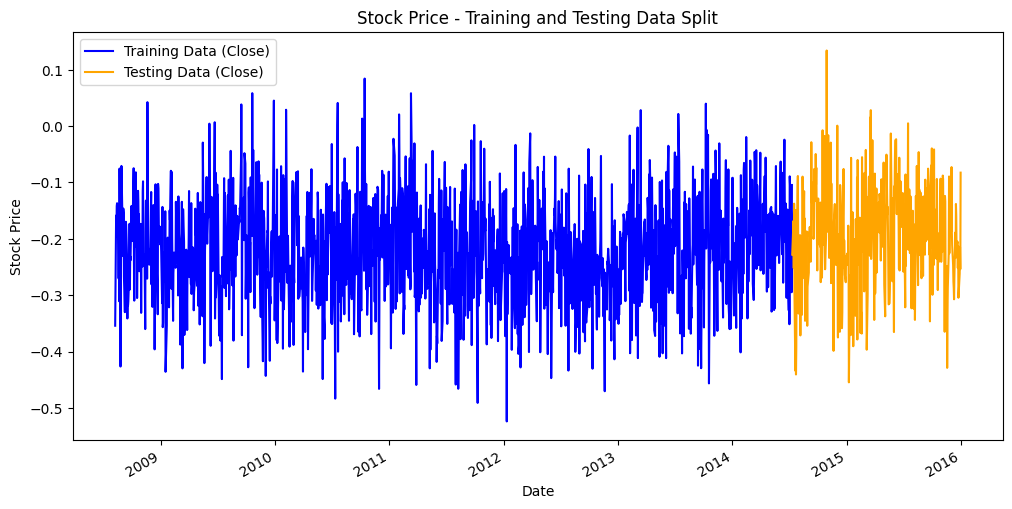

In [33]:
# Separate the original dataset into training and testing sets based on the split
train_data_len = len(X_train) + look_back  # Length of training data including look-back
train_dates = final_dataset['Date'][:train_data_len]  # Dates for the training set
test_dates = final_dataset['Date'][train_data_len:]   # Dates for the testing set

train = data[:train_data_len]  # Training set
test = data[train_data_len:]   # Testing set

# Plot the training and testing data with dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train[:, 1], label='Training Data (Close)', color='blue')  # Training data (Close price) in blue
plt.plot(test_dates, test[:, 1], label='Testing Data (Close)', color='orange')   # Testing data (Close price) in orange

# Format the x-axis for better readability (optional)
plt.gcf().autofmt_xdate()

# Add labels and title
plt.title("Stock Price - Training and Testing Data Split")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 4. Building the LSTM Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Initialize the LSTM model
model = Sequential()

# Add LSTM and Dropout layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Input shape: (timesteps, features)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))  # Dense layer with 25 neurons
model.add(Dense(1))   # Output layer for the predicted 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Training the Model

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0508 - val_loss: 0.0013
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0024 - val_loss: 6.7359e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0021 - val_loss: 6.0409e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0016 - val_loss: 4.6877e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0013 - val_loss: 4.3304e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/

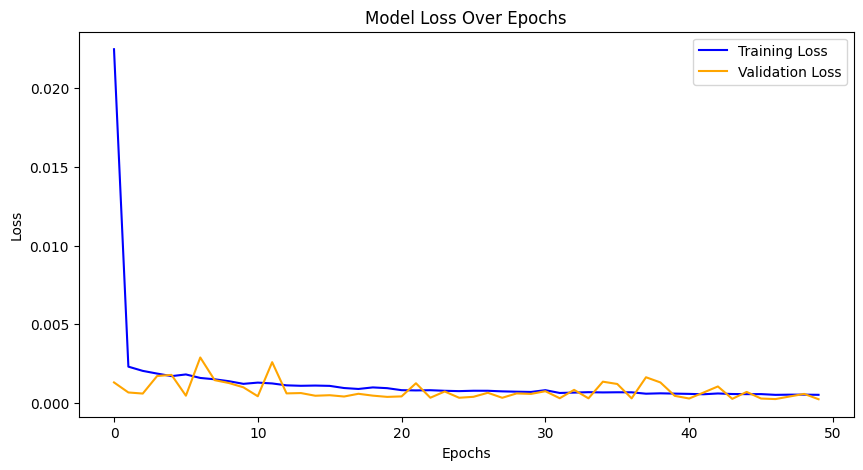

In [35]:
# Train the model on the training data with validation on a portion of it
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

# Plot training and validation loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Making Predictions and Evaluating Model Performance

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values for the 'Close' price
# Only the second column (index 1) corresponds to the actual 'Close' price in the scaled data
train_predictions_inv = scaler.inverse_transform(
    np.concatenate((np.zeros_like(train_predictions), train_predictions), axis=1)
)[:, 1]
y_train_inv = scaler.inverse_transform(
    np.concatenate((np.zeros_like(y_train.reshape(-1, 1)), y_train.reshape(-1, 1)), axis=1)
)[:, 1]

test_predictions_inv = scaler.inverse_transform(
    np.concatenate((np.zeros_like(test_predictions), test_predictions), axis=1)
)[:, 1]
y_test_inv = scaler.inverse_transform(
    np.concatenate((np.zeros_like(y_test.reshape(-1, 1)), y_test.reshape(-1, 1)), axis=1)
)[:, 1]

# Calculate RMSE for training and testing predictions
train_rmse = sqrt(mean_squared_error(y_train_inv, train_predictions_inv))
test_rmse = sqrt(mean_squared_error(y_test_inv, test_predictions_inv))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Train RMSE: 0.01111429685813448
Test RMSE: 0.014614248511870927


# 7. Plotting Predictions vs Actual Values

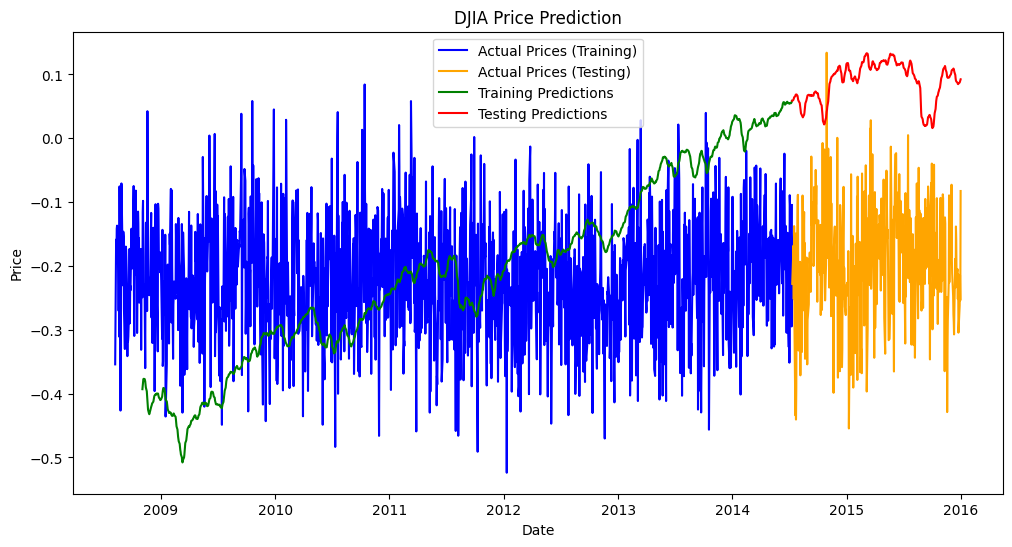

In [38]:
import matplotlib.pyplot as plt

# Inverse transform the scaled data to get original values
original_data = scaler.inverse_transform(scaled_data)

# Correct the date indices for the training and testing predictions
train_dates = final_dataset['Date'].iloc[look_back:look_back + len(train_predictions)].values
test_dates = final_dataset['Date'].iloc[look_back + len(train_predictions):look_back + len(train_predictions) + len(test_predictions)].values

# Plot actual data
plt.figure(figsize=(12, 6))
plt.plot(
    final_dataset['Date'][:look_back + len(train_predictions)],
    original_data[:look_back + len(train_predictions), 1],  # Actual 'Close' prices for training
    label='Actual Prices (Training)', color='blue'
)
plt.plot(
    final_dataset['Date'][look_back + len(train_predictions):],
    original_data[look_back + len(train_predictions):, 1],  # Actual 'Close' prices for testing
    label='Actual Prices (Testing)', color='orange'
)

# Plot training predictions
plt.plot(train_dates, train_predictions_inv, label='Training Predictions', color='green')  # Training predictions

# Plot testing predictions
plt.plot(test_dates, test_predictions_inv, label='Testing Predictions', color='red')  # Testing predictions

# Plot details
plt.title('DJIA Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()